# Evaluation of different classification algorithms for COVID-19 Pandemic Tweets

#### Stylianos Sidiropoulos (stysi607)

#### Text Mining (732A92) - Linköping University

## Load Libraries

In [ ]:
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Data Preprocessing

keep only useful columns, check for nulls, check if dataset is balanced, balance dataset, lowercase words, remove stopwords, punctuations, numbers, links, hashtags, mentions etc.

Dataset: https://www.kaggle.com/datatattle/covid-19-nlp-text-classification

In [ ]:
# Read data and merge it into one dataset
data = pd.read_csv("https://raw.githubusercontent.com/steliossid/covid19-classification/main/data.csv", encoding="latin")

not_whole_dataset = False
if not_whole_dataset:
    data = data.loc[:1000]
data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
# Keep only OriginalTweet and Sentiment columns
data.pop("UserName")
data.pop("ScreenName")
data.pop("Location")
data.pop("TweetAt")
data.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
# Check if there are null values
data.isnull().values.any()

False

In [ ]:
data.shape

(44955, 2)

In [ ]:
sentiments = data.Sentiment.unique().tolist()
sentiments

['Neutral', 'Positive', 'Extremely Negative', 'Negative', 'Extremely Positive']

### Balance Dataset

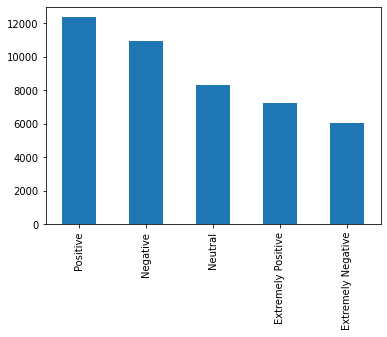

In [ ]:
data.Sentiment.value_counts().plot(kind='bar');

In [ ]:
data.Sentiment.value_counts()

Positive              12369
Negative              10958
Neutral                8332
Extremely Positive     7223
Extremely Negative     6073
Name: Sentiment, dtype: int64

Dataset is not balanced.

In [ ]:
# Balance dataset
count_min = data.Sentiment.value_counts().min()

# Divide by class and Random undersampling without replacement
df_Pos = data[data.Sentiment == "Positive"].sample(count_min)
df_Neg = data[data.Sentiment == "Negative"].sample(count_min)
df_Neu = data[data.Sentiment == "Neutral"].sample(count_min)
df_ExPos = data[data.Sentiment == "Extremely Positive"].sample(count_min)
df_ExNeg = data[data.Sentiment == "Extremely Negative"]

data_balanced = pd.concat([df_Pos, df_Neg, df_Neu, df_ExPos, df_ExNeg], axis=0)

In [ ]:
data_balanced.Sentiment.value_counts()

Extremely Negative    6073
Positive              6073
Extremely Positive    6073
Negative              6073
Neutral               6073
Name: Sentiment, dtype: int64

### Natural Language Processing (NLP)

In [ ]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'tagger', 'ner'])

def preprocess(text):
    doc = nlp(text)
    words_to_remove = ["coronavirus", "coronaviru", "covid19", "covid-19", "covid", "amp"]
    return [token.lemma_.lower() for token in doc if not token.is_stop and token.lemma_.isalpha() and len(token)>2 and token.lemma_.lower().lower() not in words_to_remove]

In [ ]:
data_balanced["ProcessedTweet"] = data_balanced["OriginalTweet"].apply(lambda x: ' '.join(preprocess(x)))
data_balanced.head()

,OriginalTweet,Sentiment,ProcessedTweet
24817,#Covid19hints. #coronavirus \r\r\n\r\r\nPlenty...,Positive,plenty chocolate easter egg supermarket cut ha...
38163,"Yes, we get it - this thing is a cloud ..!\r\r...",Positive,yes thing cloud linger air long previously thi...
15109,I left my #SelfIsolation flat just now to post...,Positive,leave selfisolation flat post letter couple bl...
34283,"Historic Grovewood Village, once home to Biltm...",Positive,historic grovewood village home biltmore indus...
25845,Costume designers like me are Creating face ma...,Positive,costume designer like creating face mask non w...


Some rows are empty after text processing, so we exclude them

In [ ]:
is_empty = data_balanced.ProcessedTweet==""
data_balanced = data_balanced[is_empty==False]

Minor change in the balance of the classes, no need to rebalance the classes

In [ ]:
data_balanced.Sentiment.value_counts()

Extremely Negative    6073
Extremely Positive    6073
Negative              6073
Positive              6072
Neutral               6034
Name: Sentiment, dtype: int64

In [ ]:
data = data_balanced.copy()
data.shape

(30325, 3)

## Statistics

### Number of words in tweet

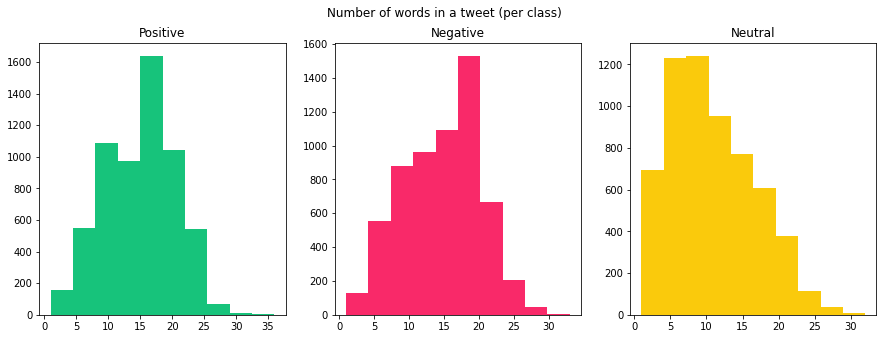

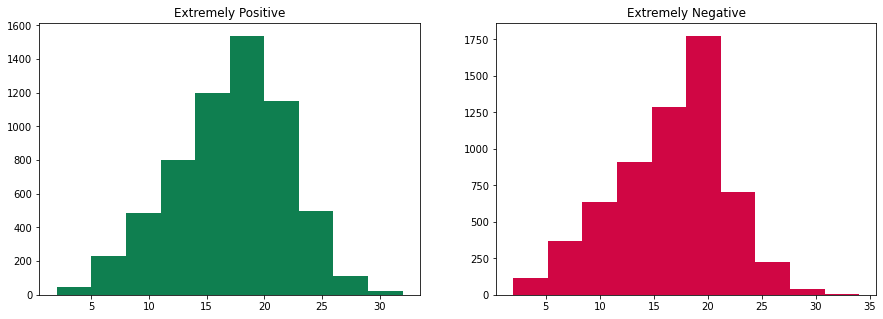

In [ ]:
fig1,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))
fig2,(ax4, ax5)=plt.subplots(1,2,figsize=(15,5))

len_pos = data[data['Sentiment']=="Positive"]['ProcessedTweet'].str.split().map(lambda x: len(x))
ax1.hist(len_pos, color='#17C37B')
ax1.set_title('Positive')

len_neg = data[data['Sentiment']=="Negative"]['ProcessedTweet'].str.split().map(lambda x: len(x))
ax2.hist(len_neg, color='#F92969')
ax2.set_title('Negative')

len_neu = data[data['Sentiment']=="Neutral"]['ProcessedTweet'].str.split().map(lambda x: len(x))
ax3.hist(len_neu, color='#FACA0C')
ax3.set_title('Neutral')

len_expos = data[data['Sentiment']=="Extremely Positive"]['ProcessedTweet'].str.split().map(lambda x: len(x))
ax4.hist(len_expos, color='#0f7f50')
ax4.set_title('Extremely Positive')

len_exneg = data[data['Sentiment']=="Extremely Negative"]['ProcessedTweet'].str.split().map(lambda x: len(x))
ax5.hist(len_exneg, color='#d00644')
ax5.set_title('Extremely Negative')

fig1.suptitle('Number of words in a tweet (per class)')
plt.show()

### Wordclouds

In [ ]:
def create_wordlist(sentiment):
    wordlist=[]
    for line in data[data["Sentiment"]==sentiment]["ProcessedTweet"].str.split():
        for word in line:
          wordlist.append(word)
    return wordlist

def create_wordcloud(sentiment):
    wordcloud = WordCloud().generate(" ".join(words for words in create_wordlist(sentiment)))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(sentiment + " " + "wordcloud")
    plt.show()

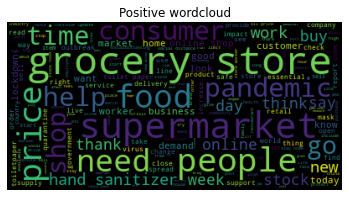

In [ ]:
create_wordcloud("Positive")

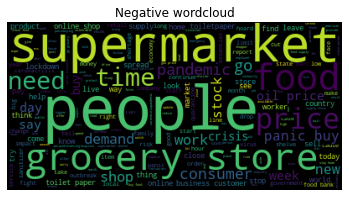

In [ ]:
create_wordcloud("Negative")

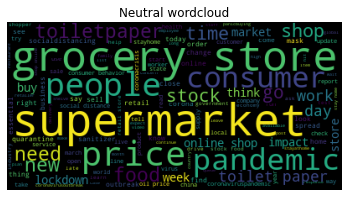

In [ ]:
create_wordcloud("Neutral")

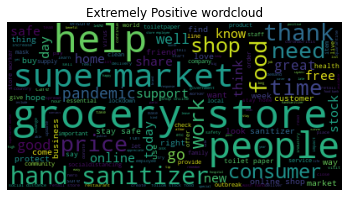

In [ ]:
create_wordcloud("Extremely Positive")

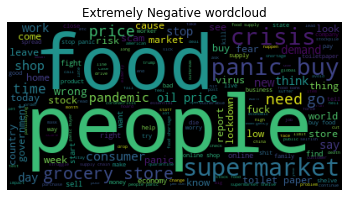

In [ ]:
create_wordcloud("Extremely Negative")

In [ ]:
def most_common_ngrams(sentiment, n_gram=1, n_common=10):
    wordlist = create_wordlist(sentiment)
    ngrams = zip(*[wordlist[i:] for i in range(n_gram)])
    counter = Counter(' '.join(ngram) for ngram in ngrams)
    return counter.most_common(n_common)

### Uni-grams

In [ ]:
most_common_ngrams("Positive")

[('store', 1399),
 ('grocery', 1188),
 ('price', 1101),
 ('food', 1096),
 ('supermarket', 1073),
 ('people', 818),
 ('shop', 805),
 ('consumer', 753),
 ('online', 627),
 ('need', 611)]

In [ ]:
most_common_ngrams("Negative")

[('price', 1485),
 ('food', 1413),
 ('store', 1209),
 ('supermarket', 1145),
 ('grocery', 1031),
 ('people', 922),
 ('shop', 681),
 ('consumer', 638),
 ('buy', 633),
 ('panic', 607)]

In [ ]:
most_common_ngrams("Neutral")

[('store', 1286),
 ('supermarket', 1114),
 ('grocery', 1028),
 ('price', 892),
 ('consumer', 871),
 ('shop', 669),
 ('food', 610),
 ('online', 542),
 ('people', 485),
 ('pandemic', 433)]

In [ ]:
most_common_ngrams("Extremely Positive")

[('store', 1399),
 ('grocery', 1066),
 ('food', 1058),
 ('help', 1053),
 ('supermarket', 1043),
 ('hand', 1005),
 ('price', 881),
 ('shop', 869),
 ('sanitizer', 842),
 ('people', 797)]

In [ ]:
most_common_ngrams("Extremely Negative")

[('food', 1875),
 ('price', 1627),
 ('panic', 1460),
 ('people', 1437),
 ('supermarket', 1110),
 ('buy', 1096),
 ('store', 1006),
 ('crisis', 885),
 ('grocery', 809),
 ('shop', 639)]

### Bi-grams

In [ ]:
most_common_ngrams("Positive", n_gram=2)

[('grocery store', 883),
 ('hand sanitizer', 330),
 ('online shop', 224),
 ('toilet paper', 178),
 ('stay home', 113),
 ('social distance', 112),
 ('store worker', 91),
 ('oil price', 89),
 ('panic buy', 80),
 ('stock food', 80)]

In [ ]:
most_common_ngrams("Negative", n_gram=2)

[('grocery store', 781),
 ('panic buy', 310),
 ('oil price', 246),
 ('toilet paper', 231),
 ('online shop', 195),
 ('food bank', 109),
 ('stay home', 97),
 ('supply chain', 92),
 ('supermarket shelve', 91),
 ('social distance', 89)]

In [ ]:
most_common_ngrams("Neutral", n_gram=2)

[('grocery store', 779),
 ('toilet paper', 245),
 ('online shop', 210),
 ('social distance', 96),
 ('consumer behavior', 88),
 ('oil price', 82),
 ('retail store', 79),
 ('stock food', 77),
 ('stay home', 73),
 ('shop online', 60)]

In [ ]:
most_common_ngrams("Extremely Positive", n_gram=2)

[('grocery store', 856),
 ('hand sanitizer', 639),
 ('online shop', 227),
 ('stay safe', 176),
 ('toilet paper', 168),
 ('stay home', 125),
 ('store worker', 121),
 ('shop online', 111),
 ('social distance', 107),
 ('wash hand', 102)]

In [ ]:
most_common_ngrams("Extremely Negative", n_gram=2)

[('panic buy', 694),
 ('grocery store', 620),
 ('oil price', 290),
 ('toilet paper', 240),
 ('buy food', 148),
 ('stop panic', 137),
 ('online shop', 122),
 ('supermarket shelve', 115),
 ('food supply', 114),
 ('supply chain', 110)]

## Models

In [ ]:
# Split train, test
X = data.ProcessedTweet
y = data.Sentiment
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Vectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=3, max_df=0.9)

def print_results(model):
  model.fit(X_train, y_train)
  y_predicted = model.predict(X_test)
  print(classification_report(y_test, y_predicted))

### Multinomial Naive Bayes

In [ ]:
# Find optimal parameters
model = Pipeline([
    ('vectorizer', tfidf_vectorizer),
    ('predictor', MultinomialNB())
])

parameters = {
    "predictor__alpha": (0.1, 1)
}

grid_search = GridSearchCV(model, parameters, cv=5, n_jobs=-1)
grid_search = grid_search.fit(X_train, y_train)

print("Grid Search Best Score: " + str(grid_search.best_score_))

for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, grid_search.best_params_[param_name]))
    
# Using optimal parameters
model = Pipeline([
    ('vectorizer', tfidf_vectorizer),
    ('predictor', MultinomialNB(alpha=grid_search.best_params_["predictor__alpha"]))
])

print_results(model)

Grid Search Best Score: 0.4844563535956466
predictor__alpha: 1
                    precision    recall  f1-score   support

Extremely Negative       0.55      0.68      0.61      1540
Extremely Positive       0.56      0.67      0.61      1553
          Negative       0.37      0.31      0.34      1508
           Neutral       0.62      0.52      0.56      1493
          Positive       0.35      0.31      0.33      1488

          accuracy                           0.50      7582
         macro avg       0.49      0.50      0.49      7582
      weighted avg       0.49      0.50      0.49      7582



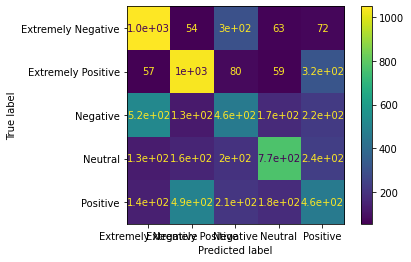

In [ ]:
plot_confusion_matrix(model, X_test, y_test)

### Logistic Regression

In [ ]:
# Find optimal parameters
model = Pipeline([
    ('vectorizer', tfidf_vectorizer),
    ('predictor', LogisticRegression(max_iter=10000))
])

parameters = {
    "predictor__C": (1,3,5),
    "predictor__penalty": ("l1", "l2")
}

grid_search = GridSearchCV(model, parameters, cv=5, n_jobs=-1)
grid_search = grid_search.fit(X_train, y_train)

print("Grid Search Best Score: " + str(grid_search.best_score_))

for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, grid_search.best_params_[param_name]))
    
# Using optimal parameters
model = Pipeline([
    ('vectorizer', tfidf_vectorizer),
    ('predictor', LogisticRegression(penalty=grid_search.best_params_["predictor__penalty"],
                                     C=grid_search.best_params_["predictor__C"],
                                     max_iter=10000))
])

print_results(model)

Grid Search Best Score: 0.5575343088152016
predictor__C: 3
predictor__penalty: 'l2'
                    precision    recall  f1-score   support

Extremely Negative       0.67      0.71      0.69      1540
Extremely Positive       0.68      0.71      0.69      1553
          Negative       0.44      0.39      0.41      1508
           Neutral       0.62      0.70      0.66      1493
          Positive       0.44      0.38      0.41      1488

          accuracy                           0.58      7582
         macro avg       0.57      0.58      0.57      7582
      weighted avg       0.57      0.58      0.57      7582



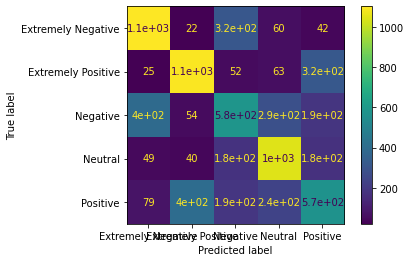

In [ ]:
plot_confusion_matrix(model, X_test, y_test)

### Random Forest Classifier

In [ ]:
# Find optimal parameters
model = Pipeline([
    ('vectorizer', tfidf_vectorizer),
    ('predictor', RandomForestClassifier())
])

parameters = {
    "predictor__max_depth": (1,5,10,50),
    "predictor__n_estimators": (5,10,100,500)
}

grid_search = GridSearchCV(model, parameters, cv=5, n_jobs=-1)
grid_search = grid_search.fit(X_train, y_train)

print("Grid Search Best Score: " + str(grid_search.best_score_))

for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, grid_search.best_params_[param_name]))
    
# Using optimal parameters
model = Pipeline([
    ('vectorizer', tfidf_vectorizer),
    ('predictor', RandomForestClassifier(max_depth=grid_search.best_params_["predictor__max_depth"], 
                                         n_estimators=grid_search.best_params_["predictor__n_estimators"],
                                         class_weight="balanced"))
])

print_results(model)

Grid Search Best Score: 0.5299211768734196
predictor__max_depth: 50
predictor__n_estimators: 500
                    precision    recall  f1-score   support

Extremely Negative       0.61      0.73      0.66      1540
Extremely Positive       0.59      0.75      0.66      1553
          Negative       0.47      0.22      0.30      1508
           Neutral       0.48      0.84      0.61      1493
          Positive       0.49      0.14      0.22      1488

          accuracy                           0.54      7582
         macro avg       0.53      0.54      0.49      7582
      weighted avg       0.53      0.54      0.49      7582



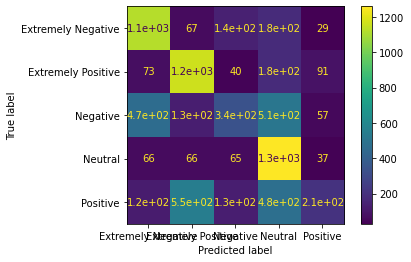

In [ ]:
plot_confusion_matrix(model, X_test, y_test)

### Decision Tree Classifier


Fine-tuning hyperparameters with Grid Search takes a lot of time, so the default values of DecisionTreeClassifier were used.

In [ ]:
# Find optimal parameters - very slow!
# model = Pipeline([
#     ('vectorizer', tfidf_vectorizer),
#     ('predictor', DecisionTreeClassifier())
# ])

# parameters = {
#     "predictor__criterion": ("gini", "entropy"),
#     "predictor__max_depth": range(1,10),
#     "predictor__min_samples_split": range(1,10),
#     "predictor__min_samples_leaf": range(1,5),
# }


# grid_search = GridSearchCV(model, parameters, cv=5, n_jobs=-1)
# grid_search = grid_search.fit(X_train, y_train)

# print("Grid Search Best Score: " + str(grid_search.best_score_))

# for param_name in sorted(parameters.keys()):
#     print("%s: %r" % (param_name, grid_search.best_params_[param_name]))
    
# Using optimal parameters
model = Pipeline([
    ('vectorizer', tfidf_vectorizer),
    ('predictor', DecisionTreeClassifier(class_weight="balanced"))
])

print_results(model)

                    precision    recall  f1-score   support

Extremely Negative       0.56      0.52      0.54      1540
Extremely Positive       0.56      0.52      0.54      1553
          Negative       0.36      0.34      0.35      1508
           Neutral       0.53      0.64      0.58      1493
          Positive       0.33      0.32      0.33      1488

          accuracy                           0.47      7582
         macro avg       0.47      0.47      0.47      7582
      weighted avg       0.47      0.47      0.47      7582



### Linear Support Vector Classifier (SVC)

In [ ]:
# Find optimal parameters
model = Pipeline([
    ('vectorizer', tfidf_vectorizer),
    ('predictor', LinearSVC(max_iter=10000))
])

parameters = {
    "predictor__penalty": ("l1", "l2")
}


grid_search = GridSearchCV(model, parameters, cv=5, n_jobs=-1)
grid_search = grid_search.fit(X_train, y_train)

print("Grid Search Best Score: " + str(grid_search.best_score_))

for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, grid_search.best_params_[param_name]))
    
# Using optimal parameters
model = Pipeline([
    ('vectorizer', tfidf_vectorizer),
    ('predictor', LinearSVC(penalty=grid_search.best_params_["predictor__penalty"],
                            class_weight="balanced", max_iter=10000))
])

print_results(model)

Grid Search Best Score: 0.5434639776049439
predictor__penalty: 'l2'
                    precision    recall  f1-score   support

Extremely Negative       0.65      0.74      0.69      1540
Extremely Positive       0.66      0.74      0.70      1553
          Negative       0.41      0.32      0.36      1508
           Neutral       0.60      0.68      0.64      1493
          Positive       0.41      0.33      0.37      1488

          accuracy                           0.56      7582
         macro avg       0.55      0.56      0.55      7582
      weighted avg       0.55      0.56      0.55      7582



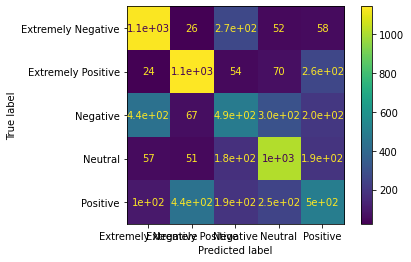

In [ ]:
plot_confusion_matrix(model, X_test, y_test)

### Stochastic Gradient Descent (SGD) Classifier

In [ ]:
# Find optimal parameters
model = Pipeline([
    ('vectorizer', tfidf_vectorizer),
    ('predictor', SGDClassifier())
])

parameters = {
    "predictor__alpha": (0.0001, 0.001, 0.01, 0.1, 1),
    "predictor__penalty": ("l1", "l2")
}

grid_search = GridSearchCV(model, parameters, cv=5, n_jobs=-1)
grid_search = grid_search.fit(X_train, y_train)

print("Grid Search Best Score: " + str(grid_search.best_score_))

for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, grid_search.best_params_[param_name]))
    
# Using optimal parameters
model = Pipeline([
    ('vectorizer', tfidf_vectorizer),
    ('predictor', SGDClassifier(alpha=grid_search.best_params_["predictor__alpha"], 
                                penalty=grid_search.best_params_["predictor__penalty"],
                                class_weight="balanced"))
])

print_results(model)

Grid Search Best Score: 0.5508068789897089
predictor__alpha: 0.0001
predictor__penalty: 'l2'
                    precision    recall  f1-score   support

Extremely Negative       0.57      0.87      0.69      1540
Extremely Positive       0.58      0.87      0.70      1553
          Negative       0.49      0.16      0.24      1508
           Neutral       0.60      0.78      0.67      1493
          Positive       0.50      0.16      0.24      1488

          accuracy                           0.57      7582
         macro avg       0.55      0.57      0.51      7582
      weighted avg       0.55      0.57      0.51      7582



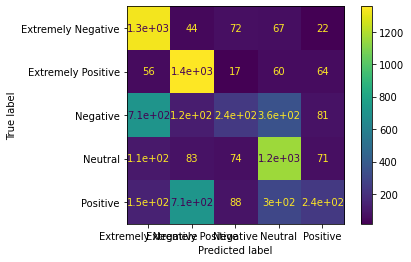

In [ ]:
plot_confusion_matrix(model, X_test, y_test)

### Extreme Gradient Boosting Classifier (XGB)

Fine-tuning hyperparameters with Grid Search takes a lot of time, so custom values of XGBClassifier were used.

In [ ]:
# # Find optimal parameters - very slow!
# model = Pipeline([
#     ('vectorizer', tfidf_vectorizer),
#     ('predictor', XGBClassifier())
# ])

# parameters = {
#     "predictor__learning_rate": (0.0001, 0.001, 0.01, 0.1),
#     "predictor__max_depth": (1,3,5,7),
#     "predictor__no_estimators": (5,10,100,500)
# }

# grid_search = GridSearchCV(model, parameters, cv=5, n_jobs=-1)
# grid_search = grid_search.fit(X_train, y_train)

# print("Grid Search Best Score: " + str(grid_search.best_score_))

# for param_name in sorted(parameters.keys()):
#     print("%s: %r" % (param_name, grid_search.best_params_[param_name]))
    
# Using optimal parameters
model = Pipeline([
    ('vectorizer', tfidf_vectorizer),
    ('predictor', XGBClassifier(learning_rate=0.1, max_depth=7, no_estimators=200,
                                colsample_bytree=0.8, subsample=0.8, nthread=10))
])

print_results(model)

                    precision    recall  f1-score   support

Extremely Negative       0.65      0.63      0.64      1540
Extremely Positive       0.65      0.65      0.65      1553
          Negative       0.43      0.28      0.34      1508
           Neutral       0.47      0.84      0.60      1493
          Positive       0.40      0.25      0.31      1488

          accuracy                           0.53      7582
         macro avg       0.52      0.53      0.51      7582
      weighted avg       0.52      0.53      0.51      7582



### Neural Networks

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

max_len = np.max(X_train.apply(lambda x :len(x)))

tokenizer = Tokenizer()

tokenizer.fit_on_texts(X_train)
vocab_length = len(tokenizer.word_index) + 1

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

X_train = pad_sequences(X_train, maxlen=max_len, padding='post')
X_test = pad_sequences(X_test, maxlen=max_len, padding='post')

embedding_dim = 16

tf.keras.backend.clear_session()
model = Sequential([
    Embedding(vocab_length, embedding_dim, input_length=max_len),
    Bidirectional(GRU(256, return_sequences=True)),
    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(5, activation='softmax')
])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 244, 16)           428896    
_________________________________________________________________
bidirectional (Bidirectional (None, 244, 512)          420864    
_________________________________________________________________
global_average_pooling1d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                32832     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 882,917
Trainable params: 882,917
Non-trainable params: 0
__________________________________________________

In [ ]:
l = {"Neutral":0, "Positive":1, "Negative":2, "Extremely Positive":3, "Extremely Negative":4}
y_train.replace(l, inplace=True)
y_test.replace(l, inplace=True)

num_epochs = 5

model.compile(loss=SparseCategoricalCrossentropy(), optimizer="adam", metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(X_test, y_test))

Epoch 1/5
711/711 [==============================] - 24s 34ms/step - loss: 1.5746 - accuracy: 0.2398 - val_loss: 1.3494 - val_accuracy: 0.4305
Epoch 2/5
711/711 [==============================] - 24s 33ms/step - loss: 1.0270 - accuracy: 0.5930 - val_loss: 0.8912 - val_accuracy: 0.6683
Epoch 3/5
711/711 [==============================] - 24s 33ms/step - loss: 0.7769 - accuracy: 0.7205 - val_loss: 0.8392 - val_accuracy: 0.6778
Epoch 4/5
711/711 [==============================] - 24s 33ms/step - loss: 0.6629 - accuracy: 0.7705 - val_loss: 0.8874 - val_accuracy: 0.6850
Epoch 5/5
711/711 [==============================] - 24s 33ms/step - loss: 0.5667 - accuracy: 0.8140 - val_loss: 0.9193 - val_accuracy: 0.6807


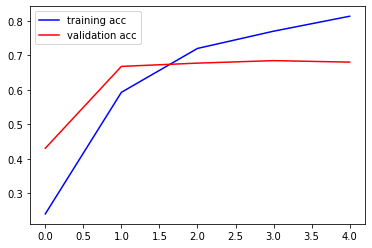

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))

plt.plot(epochs, acc,'b',label='training acc')
plt.plot(epochs, val_acc, 'r', label='validation acc')
plt.legend()
plt.show()

In [ ]:
print(classification_report(y_test,model.predict_classes(X_test)))

              precision    recall  f1-score   support

           0       0.78      0.71      0.74      1524
           1       0.53      0.62      0.57      1488
           2       0.53      0.57      0.55      1502
           3       0.85      0.71      0.78      1537
           4       0.78      0.79      0.78      1531

    accuracy                           0.68      7582
   macro avg       0.69      0.68      0.68      7582
weighted avg       0.70      0.68      0.69      7582

